## Movie-Level Clustering (KMeans + PCA Visualization)

This notebook performs an unsupervised segmentation of movies to identify meaningful groups based on interpretable pre-release and market-related attributes (e.g., budget, genre, timing, early signals). The goal is to generate actionable clusters that can support studio decision-making around release timing and expected revenue patterns.


### Workflow Overview - Movie-Level Clustering (KMeans)

1) **Load movie-level dataset (source of truth).**  
   Import the merged, cleaned movie table and validate key columns needed for segmentation (e.g., budget, opening weekend, prerelease reviews, release date, genre, revenue for interpretation).

2) **Create a movie-level profile table.**  
   Ensure *one row per movie* (deduplicate by `movie_id`) and keep a set of **interpretable business variables** that later allow cluster profiling.

3) **Parse and engineer timing features.**  
   Convert release date strings into usable temporal features (e.g., `release_month`, `release_quarter`). This enables alignment with “seasonality” perspectives even when dates are partially missing.

4) **Coerce numeric variables + log-transform scale-sensitive features.**  
   Convert financial variables to numeric and apply `log1p` transforms (e.g., `budget_log`) to reduce skewness and keep patterns comparable across blockbusters vs smaller films.

5) **Encode genres for clustering.**  
   Split the genre string into lists and apply **multi-hot encoding** (MultiLabelBinarizer) so genre membership becomes structured signals in the clustering matrix.

6) **Assemble the clustering matrix (features used to create clusters).**  
   Combine selected numeric predictors (budget, opening weekend, prerelease reviews, timing) + genre dummies into a single feature matrix.  
   *Revenue is kept for interpretation only (profiling), not used for clustering to avoid “segmenting by outcome.”*

7) **Impute + scale features.**  
   Apply simple imputation (median for numeric, zeros for dummies) and then standardize features so KMeans is not dominated by large-scale variables.

8) **Select k using elbow + silhouette diagnostics.**  
   Train KMeans over a range of k values, store inertia and silhouette scores, and select the best k (either analytically or automatically via max silhouette).

9) **Fit final KMeans and assign clusters.**  
   Train KMeans with the chosen k and store the cluster label per movie.

10) **Visualize clusters in 2D PCA space.**  
   Project scaled features into 2 principal components and plot clusters to confirm separation and detect overlap/outliers.

11) **Profile clusters with business variables (interpretation).**  
   Build a cluster profile table (counts + averages of budget, opening weekend, prerelease reviews, timing patterns, and revenue log for interpretation) to translate clusters into business-relevant segments.


In [1]:
# Virginia Bustos
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42


In [2]:
# Virginia Bustos
df_movies = pd.read_parquet("merged_cleaned_movies.parquet")

print("Loaded merged_cleaned_movies.parquet")
print("Shape:", df_movies.shape)
print("Columns:", df_movies.columns.tolist())
df_movies.head()


Loaded merged_cleaned_movies.parquet
Shape: (65115, 8)
Columns: ['genre', 'opening_weekend', 'production_budget', 'release_date', 'movie_id', 'cleaned_title', 'prerelease_reviews', 'total_revenue']


,genre,opening_weekend,production_budget,release_date,movie_id,cleaned_title,prerelease_reviews,total_revenue
index,,,,,,,,
8,Documentary,5791.0,NaN,June 1st,33445,women art revolution,"'Thankfully, Lynn Hershman-Leeson s loosely o...",52681.0
11,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",24727437.0,15000000.0,March 11th,10,10 cloverfield lane,"'Economically told from the start, the film m...",108286422.0
12,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",24727437.0,15000000.0,March 11th,10,10 cloverfield lane,'This is a terrific movie that will keep audi...,108286422.0
13,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",24727437.0,15000000.0,March 11th,10,10 cloverfield lane,"'Sneakily tweaking our fears of terrorism, 10...",108286422.0
14,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",24727437.0,15000000.0,March 11th,10,10 cloverfield lane,'Approach 10 Cloverfield Lane on its own term...,108286422.0


**Build an interpretable movie profile for clustering**

We create a compact, interpretable feature table that aligns with the business questions: budget (investment), timing (release month/quarter), genre (content category), and early signals (pre-release review count and opening weekend).  
This step ensures that clusters remain explainable and decision-relevant.


In [3]:
# Virginia Bustos
# Ensure one row per movie_id (movie-level)
df_movies_unique = df_movies.drop_duplicates(subset=["movie_id"]).copy()

# Keep only the columns we actually have 

movie_profile = df_movies_unique[[
    "movie_id",
    "cleaned_title",
    "genre",
    "release_date",
    "production_budget",
    "opening_weekend",
    "prerelease_reviews",
    "total_revenue"
]].copy()

print("Movie profile shape:", movie_profile.shape)
movie_profile.head()


Movie profile shape: (3475, 8)


,movie_id,cleaned_title,genre,release_date,production_budget,opening_weekend,prerelease_reviews,total_revenue
index,,,,,,,,
8,33445,women art revolution,Documentary,June 1st,NaN,5791.0,"'Thankfully, Lynn Hershman-Leeson s loosely o...",52681.0
11,10,10 cloverfield lane,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",March 11th,15000000.0,24727437.0,"'Economically told from the start, the film m...",108286422.0
54,25,10 years,"Comedy, Drama, Romance",September 14th,NaN,22707.0,"'There s a relaxed, unforced, melancholy swee...",987640.0
72,29,100 bloody acres,"Black Comedy, Comedy, Horror",June 28th,NaN,3419.0,'Don t see this movie if you have a weak stom...,6388.0
94,43,10000 km,"Comedy, Drama, Romance",July 10th,NaN,NaN,"'It s hard to know what to make of this, but ...",20452.0


**Feature engineering: timing variables and log transforms**

To capture seasonality and mitigate skewed financial distributions, we:  
- extract month and quarter from release date (using a dummy year if needed), and  
- compute log-transformed budget and revenue for robust comparisons.


In [4]:
# Virginia Bustos

#Feature engineering: timing variables & log transforms

# Parse the release_date column into a datetime format.
# Since the original values contain only month/day (e.g., "June 1st"),
# we prepend a dummy year ("2000") to enable consistent datetime parsing.
movie_profile["release_date_parsed"] = pd.to_datetime(
    "2000 " + movie_profile["release_date"].astype(str),  # convert to string and add dummy year
    errors="coerce"                                       # invalid dates are set to NaT
)

# Extract the release month as a numeric feature (1–12),
# commonly used to capture seasonality effects in box-office performance.
movie_profile["release_month"] = movie_profile["release_date_parsed"].dt.month

# Extract the release quarter (1–4),
# providing a coarser representation of release timing.
movie_profile["release_quarter"] = movie_profile["release_date_parsed"].dt.quarter

# Numeric type coercion

# Convert production budget to numeric format.
# Non-numeric or malformed values are coerced to NaN.
movie_profile["production_budget_num"] = pd.to_numeric(
    movie_profile["production_budget"], errors="coerce"
)

# Convert opening weekend revenue to numeric format.
movie_profile["opening_weekend_num"] = pd.to_numeric(
    movie_profile["opening_weekend"], errors="coerce"
)

# Convert the number of pre-release expert reviews to numeric format.
movie_profile["prerelease_reviews_num"] = pd.to_numeric(
    movie_profile["prerelease_reviews"], errors="coerce"
)

# Convert total box-office revenue to numeric format.
movie_profile["total_revenue_num"] = pd.to_numeric(
    movie_profile["total_revenue"], errors="coerce"
)

# Log transformations 

# Apply log(1 + x) transformation to production budget
# to reduce right-skewness and stabilize variance.
movie_profile["budget_log"] = np.log1p(
    movie_profile["production_budget_num"]
)

# Apply log(1 + x) transformation to total revenue
# to improve comparability across movies with very different scales.
movie_profile["revenue_log"] = np.log1p(
    movie_profile["total_revenue_num"]
)

# Data quality checks 

# Report missingness in timing features after parsing.
print("Parsed timing missingness:")
print(
    movie_profile[["release_month", "release_quarter"]]
    .isna()
    .mean()
    .round(3)
)

# Report missingness in production budget after numeric coercion.
print("\nBudget missingness:",
      movie_profile["production_budget_num"].isna().mean().round(3))

# Report missingness in total revenue after numeric coercion.
print("Revenue missingness:",
      movie_profile["total_revenue_num"].isna().mean().round(3))

# Preview the resulting dataframe to verify transformations.
movie_profile.head()



Parsed timing missingness:
release_month      0.914
release_quarter    0.914
dtype: float64

Budget missingness: 0.642
Revenue missingness: 0.0


,movie_id,cleaned_title,genre,release_date,production_budget,opening_weekend,prerelease_reviews,total_revenue,release_date_parsed,release_month,release_quarter,production_budget_num,opening_weekend_num,prerelease_reviews_num,total_revenue_num,budget_log,revenue_log
index,,,,,,,,,,,,,,,,,
8,33445,women art revolution,Documentary,June 1st,NaN,5791.0,"'Thankfully, Lynn Hershman-Leeson s loosely o...",52681.0,2000-06-01,6.0,2.0,NaN,5791.0,NaN,52681.0,NaN,10.872029
11,10,10 cloverfield lane,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",March 11th,15000000.0,24727437.0,"'Economically told from the start, the film m...",108286422.0,NaT,NaN,NaN,15000000.0,24727437.0,NaN,108286422.0,16.523561,18.500290
54,25,10 years,"Comedy, Drama, Romance",September 14th,NaN,22707.0,"'There s a relaxed, unforced, melancholy swee...",987640.0,NaT,NaN,NaN,NaN,22707.0,NaN,987640.0,NaN,13.803075
72,29,100 bloody acres,"Black Comedy, Comedy, Horror",June 28th,NaN,3419.0,'Don t see this movie if you have a weak stom...,6388.0,NaT,NaN,NaN,NaN,3419.0,NaN,6388.0,NaN,8.762333
94,43,10000 km,"Comedy, Drama, Romance",July 10th,NaN,NaN,"'It s hard to know what to make of this, but ...",20452.0,NaT,NaN,NaN,NaN,NaN,NaN,20452.0,NaN,9.925885


The missingness analysis reveals substantial sparsity in the parsed release timing variables, with approximately 91% of observations lacking valid month and quarter information. This limitation reflects inconsistencies in the original release date formatting and restricts the strength of temporal interpretations at the movie level. Production budget data also exhibits a high level of missingness (64%), indicating that budget-related insights should be interpreted cautiously. In contrast, revenue information is fully observed, supporting its reliable use as an outcome variable for post-clustering interpretation rather than as a driver of cluster formation.


**Encode genre and assemble the clustering feature matrix**

Genres are multi-label categorical variables. We transform them into a multi-hot representation using a MultiLabelBinarizer.  
We then combine genre features with numeric decision-relevant signals and standardize the matrix to ensure distance-based clustering is not dominated by feature scale.


In [5]:
# Virginia Bustos

# Genre processing & feature matrix construction for clustering 

# Parse the genre column into a list of individual genres.
# Missing values are replaced with "Unknown" to preserve observations.
# Genres are split by comma and stripped of whitespace.
movie_profile["genre_list"] = (
    movie_profile["genre"]
    .fillna("Unknown")                      # handle missing genre information
    .astype(str)                            # ensure string type
    .str.split(",")                         # split multi-genre strings into lists
    .apply(lambda xs: [x.strip() for x in xs if x.strip() != ""])  # clean tokens
)


# Multi-hot encoding of genres

# Initialize a MultiLabelBinarizer to encode multi-genre membership.
# Each genre becomes a binary feature (0/1).
mlb = MultiLabelBinarizer()

# Fit the binarizer on the genre lists and transform them into a matrix.
# Column names are prefixed with "genre_" for clarity and interpretability.
genre_ohe = pd.DataFrame(
    mlb.fit_transform(movie_profile["genre_list"]),
    columns=[f"genre_{g}" for g in mlb.classes_],
    index=movie_profile.index
)

# Feature selection for clustering


# Select numeric, interpretable features that describe movie characteristics.
# Importantly, we EXCLUDE revenue from clustering to avoid "clustering by outcome".
# Revenue is used later only for ex-post interpretation of clusters.
num_features_for_clustering = [
    "budget_log",               # log-transformed production budget
    "opening_weekend_num",      # opening weekend revenue
    "prerelease_reviews_num",   # volume of early expert reviews
    "release_month",            # seasonal release timing
    "release_quarter"           # coarse seasonal timing
]

# Combine numeric features and genre dummy variables
# into a single clustering design matrix.
X_cluster_raw = pd.concat(
    [movie_profile[num_features_for_clustering], genre_ohe],
    axis=1
)


# Imputation for clustering  

# Create a copy of the clustering matrix for imputation.
X_cluster_imputed = X_cluster_raw.copy()

# Apply median imputation to numeric features.
# Median is robust to skewed distributions common in movie budgets and revenues.
X_cluster_imputed[num_features_for_clustering] = (
    X_cluster_imputed[num_features_for_clustering]
    .fillna(X_cluster_imputed[num_features_for_clustering].median(numeric_only=True))
)

# Replace remaining missing values (e.g., absent genres) with 0,
# which is appropriate for binary genre indicators.
X_cluster_imputed = X_cluster_imputed.fillna(0)

# FEATURE SCALING

# Standardize all features (mean = 0, std = 1),
# a necessary step for distance-based algorithms such as KMeans.
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster_imputed)

# SANITY CHECKS

# Print matrix dimensions to verify correct feature construction.
print("Clustering matrix shape:", X_cluster_imputed.shape)
print("Numeric features:", len(num_features_for_clustering))
print("Genre dummies:", genre_ohe.shape[1])
print("Total features:", X_cluster_imputed.shape[1])



Clustering matrix shape: (3475, 34)
Numeric features: 5
Genre dummies: 29
Total features: 34


The final clustering matrix consists of 3,475 movies described by 34 features. This representation combines a small set of numeric business and timing variables with a richer genre-based multi-hot encoding, allowing the clustering process to capture both economic characteristics and content-related structure at the movie level.


**Select the number of clusters (Elbow + Silhouette)**

We evaluate multiple values of *k* using:  
- **Inertia (Elbow method)** for compactness, and  
- **Silhouette score** for cluster separation quality.  

This provides an evidence-based justification for selecting the final number of clusters.


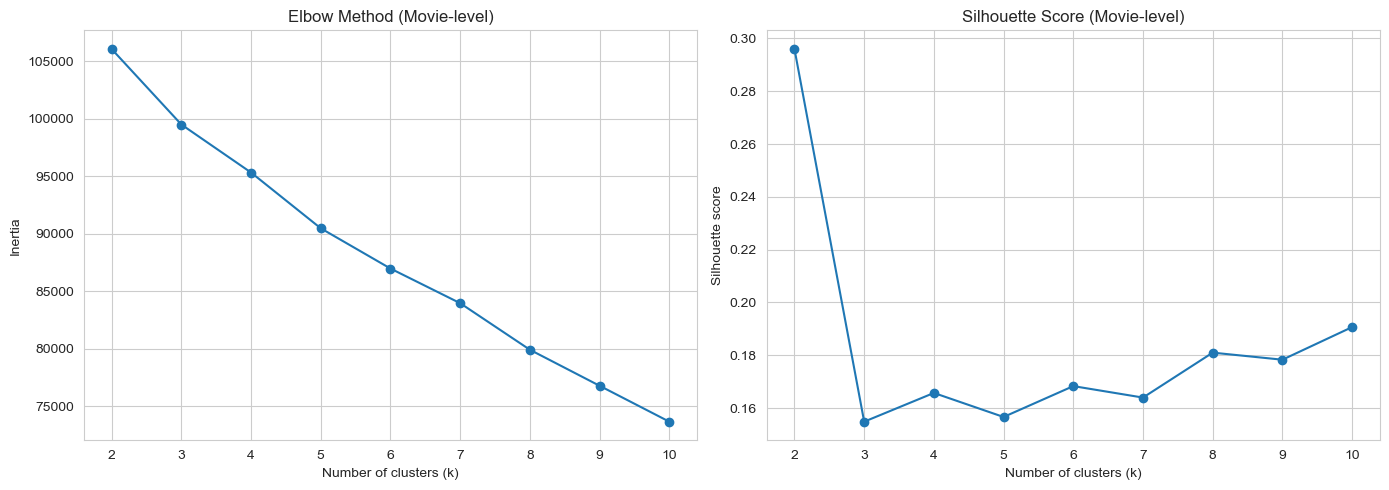

Silhouette scores by k:
k=2: silhouette=0.2960
k=3: silhouette=0.1548
k=4: silhouette=0.1657
k=5: silhouette=0.1566
k=6: silhouette=0.1683
k=7: silhouette=0.1640
k=8: silhouette=0.1810
k=9: silhouette=0.1783
k=10: silhouette=0.1906


In [6]:
# Virginia Bustos

# Elbow and silhouette analysis for optimal number of clusters

# Define the range of k (number of clusters) to evaluate.
# We test small-to-moderate values to balance interpretability and model flexibility.
k_range = range(2, 11)

# Initialize lists to store clustering diagnostics.
inertia = []      # Within-cluster sum of squares (Elbow Method)
sil_scores = []   # Average silhouette score (cluster separation quality)

# Iterate over candidate values of k
for k in k_range:
    # Initialize KMeans with fixed random state for reproducibility.
    # n_init=20 improves stability by running the algorithm multiple times.
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    
    # Fit KMeans on the scaled clustering matrix and obtain cluster labels.
    labels = km.fit_predict(X_cluster_scaled)
    
    # Store inertia (lower values indicate tighter clusters).
    inertia.append(km.inertia_)
    
    # Compute silhouette score (higher values indicate better separation).
    sil_scores.append(silhouette_score(X_cluster_scaled, labels))

# Visualization of clustering diagnostics

# Create a side-by-side figure for Elbow and Silhouette methods.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Elbow Method plot
ax[0].plot(list(k_range), inertia, marker="o")
ax[0].set_title("Elbow Method (Movie-level)")
ax[0].set_xlabel("Number of clusters (k)")
ax[0].set_ylabel("Inertia")

# Silhouette Score plot
ax[1].plot(list(k_range), sil_scores, marker="o")
ax[1].set_title("Silhouette Score (Movie-level)")
ax[1].set_xlabel("Number of clusters (k)")
ax[1].set_ylabel("Silhouette score")

# Adjust layout for readability.
plt.tight_layout()
plt.show()

# Numerical output of silhouette scores

# Print silhouette scores for each k to support transparent model selection.
print("Silhouette scores by k:")
for k, s in zip(k_range, sil_scores):
    print(f"k={k}: silhouette={s:.4f}")



The elbow curve shows a steady reduction in inertia as the number of clusters increases, without a sharply defined elbow point, suggesting gradual gains in compactness rather than a single optimal cut. In contrast, the silhouette analysis indicates the strongest cluster separation at k = 2, with a substantially higher silhouette score compared to larger k values. While higher k values yield marginal improvements in inertia, they do so at the cost of reduced cluster separation. Based on this trade-off, k = 2 is selected as the optimal solution, providing the clearest and most interpretable segmentation at the movie level.


**Fit the final KMeans model and assign cluster labels**

Based on the Elbow and Silhouette diagnostics, we select an optimal *k* and fit the final KMeans model.  
Cluster labels are assigned at the movie level to enable downstream profiling and managerial interpretation.


In [7]:
# Virginia Bustos

# Automatic selection of the optimal number of clusters and final KMeans fitting

# Convert the tested k values into a list for indexing.
k_values = list(k_range)

# Convert silhouette scores into a NumPy array for numerical operations.
silhouette_array = np.array(sil_scores)

# Select the value of k that maximizes the silhouette score.
# This ensures the chosen clustering has the best average separation between clusters.
K_OPTIMAL = k_values[np.argmax(silhouette_array)]

# Report the automatically selected optimal k and its silhouette score.
print(f"optimal k based on silhouette score: {K_OPTIMAL}")
print(f"Silhouette score at k={K_OPTIMAL}: {max(silhouette_array):.4f}")

# Initialize the final KMeans model using the optimal number of clusters.
# A higher n_init improves robustness by reducing sensitivity to initialization.
kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=RANDOM_STATE, n_init=30)

# Fit KMeans on the scaled clustering matrix and assign cluster labels
# to each movie in the movie-level profile.
movie_profile["cluster"] = kmeans.fit_predict(X_cluster_scaled)

# Display the distribution of movies across clusters
# to check balance and interpretability.
print("Cluster distribution:")
print(movie_profile["cluster"].value_counts().sort_index())

# Show a preview linking movies to their assigned clusters.
movie_profile[["movie_id", "cleaned_title", "cluster"]].head()


optimal k based on silhouette score: 2
Silhouette score at k=2: 0.2960
Cluster distribution:
cluster
0     309
1    3166
Name: count, dtype: int64


,movie_id,cleaned_title,cluster
index,,,
8,33445,women art revolution,1
11,10,10 cloverfield lane,1
54,25,10 years,1
72,29,100 bloody acres,1
94,43,10000 km,1


Based on the silhouette criterion, the optimal number of clusters is k = 2, achieving a silhouette score of 0.296, which indicates the strongest separation observed across all tested configurations. The resulting cluster distribution is notably unbalanced, with one large cluster containing the majority of movies and a smaller cluster representing a distinct subset. This asymmetry suggests the presence of a dominant release strategy alongside a more specialized group of films with differentiated economic or content characteristics, warranting further cluster-level profiling.


**Visualize clusters in 2D using PCA**

To communicate results clearly, we project the standardized clustering matrix into two dimensions using PCA.  
This visualization supports qualitative inspection of separation and overlap between movie clusters.


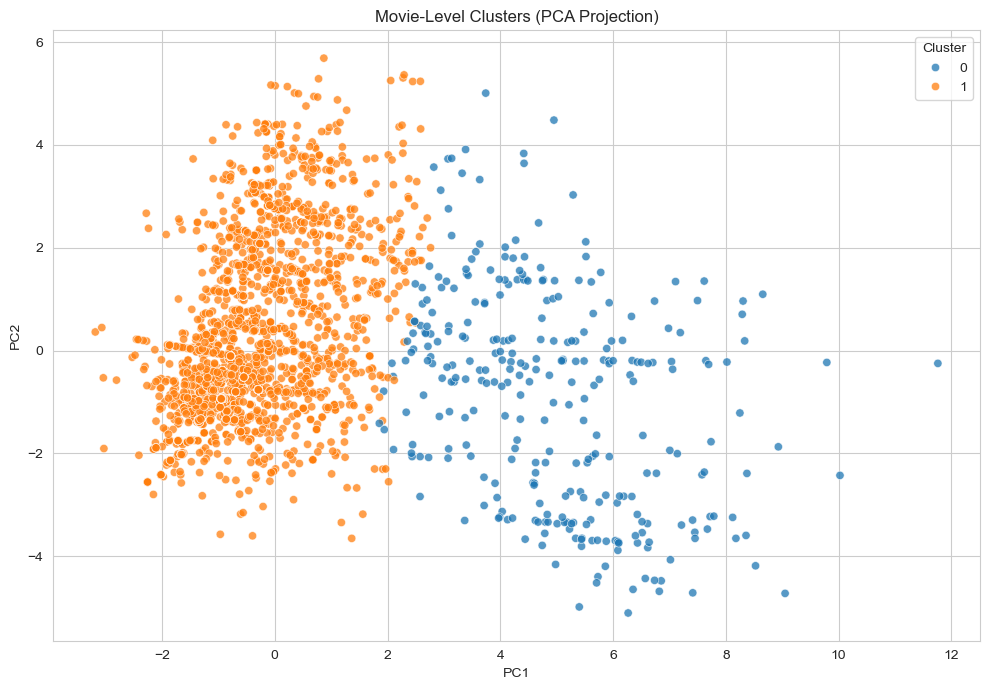

In [8]:
# Virginia Bustos

# PCA projection for 2D visualization of movie-level clusters

# Initialize PCA to reduce the high-dimensional clustering space
# to two principal components for visualization purposes.
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)

# Fit PCA on the scaled clustering feature matrix and project it into 2D space.
X_2d = pca_2d.fit_transform(X_cluster_scaled)

# Create a figure with a suitable size for academic visualization.
plt.figure(figsize=(10, 7))

# Scatter plot of movies in the 2D PCA space, colored by cluster assignment.
sns.scatterplot(
    x=X_2d[:, 0],                 # First principal component
    y=X_2d[:, 1],                 # Second principal component
    hue=movie_profile["cluster"], # Cluster labels for color coding
    palette="tab10",              # Distinct color palette for clusters
    alpha=0.75                    # Transparency to reduce overplotting
)

# Add an informative title describing what the plot represents.
plt.title("Movie-Level Clusters (PCA Projection)")

# Label axes to indicate principal components.
plt.xlabel("PC1")
plt.ylabel("PC2")

# Add a legend to identify clusters.
plt.legend(title="Cluster")

# Optimize layout spacing to avoid overlapping elements.
plt.tight_layout()

# Render the plot.
plt.show()



The PCA projection reveals a clear separation between the two clusters along the first principal component, indicating that a dominant underlying dimension drives the segmentation. While some overlap is present, particularly around the boundary region, the clusters occupy distinct regions of the reduced feature space. This visual separation supports the silhouette-based selection of k = 2 and suggests that the identified clusters capture meaningful structural differences in movie characteristics rather than random variation.


**Cluster profiling for business interpretation**

We profile clusters using interpretable statistics (budget, opening weekend, pre-release review volume, timing) and compare *revenue* outcomes across clusters (for interpretation only).  
This step converts unsupervised clusters into actionable segments that can inform release window and forecasting strategies.


In [9]:
# Virginia Bustos

# Profile numeric characteristics and release timing by cluster

# Group the movie-level dataset by cluster assignment
# and compute descriptive statistics for interpretation.
cluster_profile = (
    movie_profile.groupby("cluster")                     # Group movies by their assigned cluster
    .agg(
        n_movies=("movie_id", "count"),                   # Number of movies in each cluster

        avg_budget_log=("budget_log", "mean"),            # Average log production budget
        avg_opening_weekend=("opening_weekend_num", "mean"),  # Average opening weekend revenue
        avg_prerelease_reviews=("prerelease_reviews_num", "mean"),  # Average number of pre-release reviews

        # Identify the most common release month within each cluster
        most_common_month=(
            "release_month",
            lambda x: x.value_counts().idxmax() if x.notna().any() else np.nan
        ),

        # Average log revenue (used only for post-clustering interpretation, not for clustering itself)
        avg_revenue_log=("revenue_log", "mean")
    )
    .round(3)                                             # Round values for cleaner presentation
)

# Display the cluster-level profile table
cluster_profile


,n_movies,avg_budget_log,avg_opening_weekend,avg_prerelease_reviews,most_common_month,avg_revenue_log
cluster,,,,,,
0,309,18.401,4.632069e+07,NaN,12.0,18.650
1,3166,16.409,4.272547e+06,NaN,8.0,11.472


In [10]:
#Virginia Bustos 
movie_clusters_out = movie_profile[[
    "movie_id",
    "cleaned_title",
    "genre",
    "release_date",
    "release_month",
    "release_quarter",
    "budget_log",
    "prerelease_reviews_num",
    "opening_weekend_num",
    "revenue_log",
    "cluster"
]].copy()

movie_clusters_out.to_parquet("movie_level_clusters.parquet", index=False)

print("Saved: movie_level_clusters.parquet")
print("Output shape:", movie_clusters_out.shape)
movie_clusters_out.head()


Saved: movie_level_clusters.parquet
Output shape: (3475, 11)


,movie_id,cleaned_title,genre,release_date,release_month,release_quarter,budget_log,prerelease_reviews_num,opening_weekend_num,revenue_log,cluster
index,,,,,,,,,,,
8,33445,women art revolution,Documentary,June 1st,6.0,2.0,NaN,NaN,5791.0,10.872029,1
11,10,10 cloverfield lane,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",March 11th,NaN,NaN,16.523561,NaN,24727437.0,18.500290,1
54,25,10 years,"Comedy, Drama, Romance",September 14th,NaN,NaN,NaN,NaN,22707.0,13.803075,1
72,29,100 bloody acres,"Black Comedy, Comedy, Horror",June 28th,NaN,NaN,NaN,NaN,3419.0,8.762333,1
94,43,10000 km,"Comedy, Drama, Romance",July 10th,NaN,NaN,NaN,NaN,NaN,9.925885,1


**Cluster Dashboard**

C:\Users\arian\AppData\Local\Temp\ipykernel_19652\243169566.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


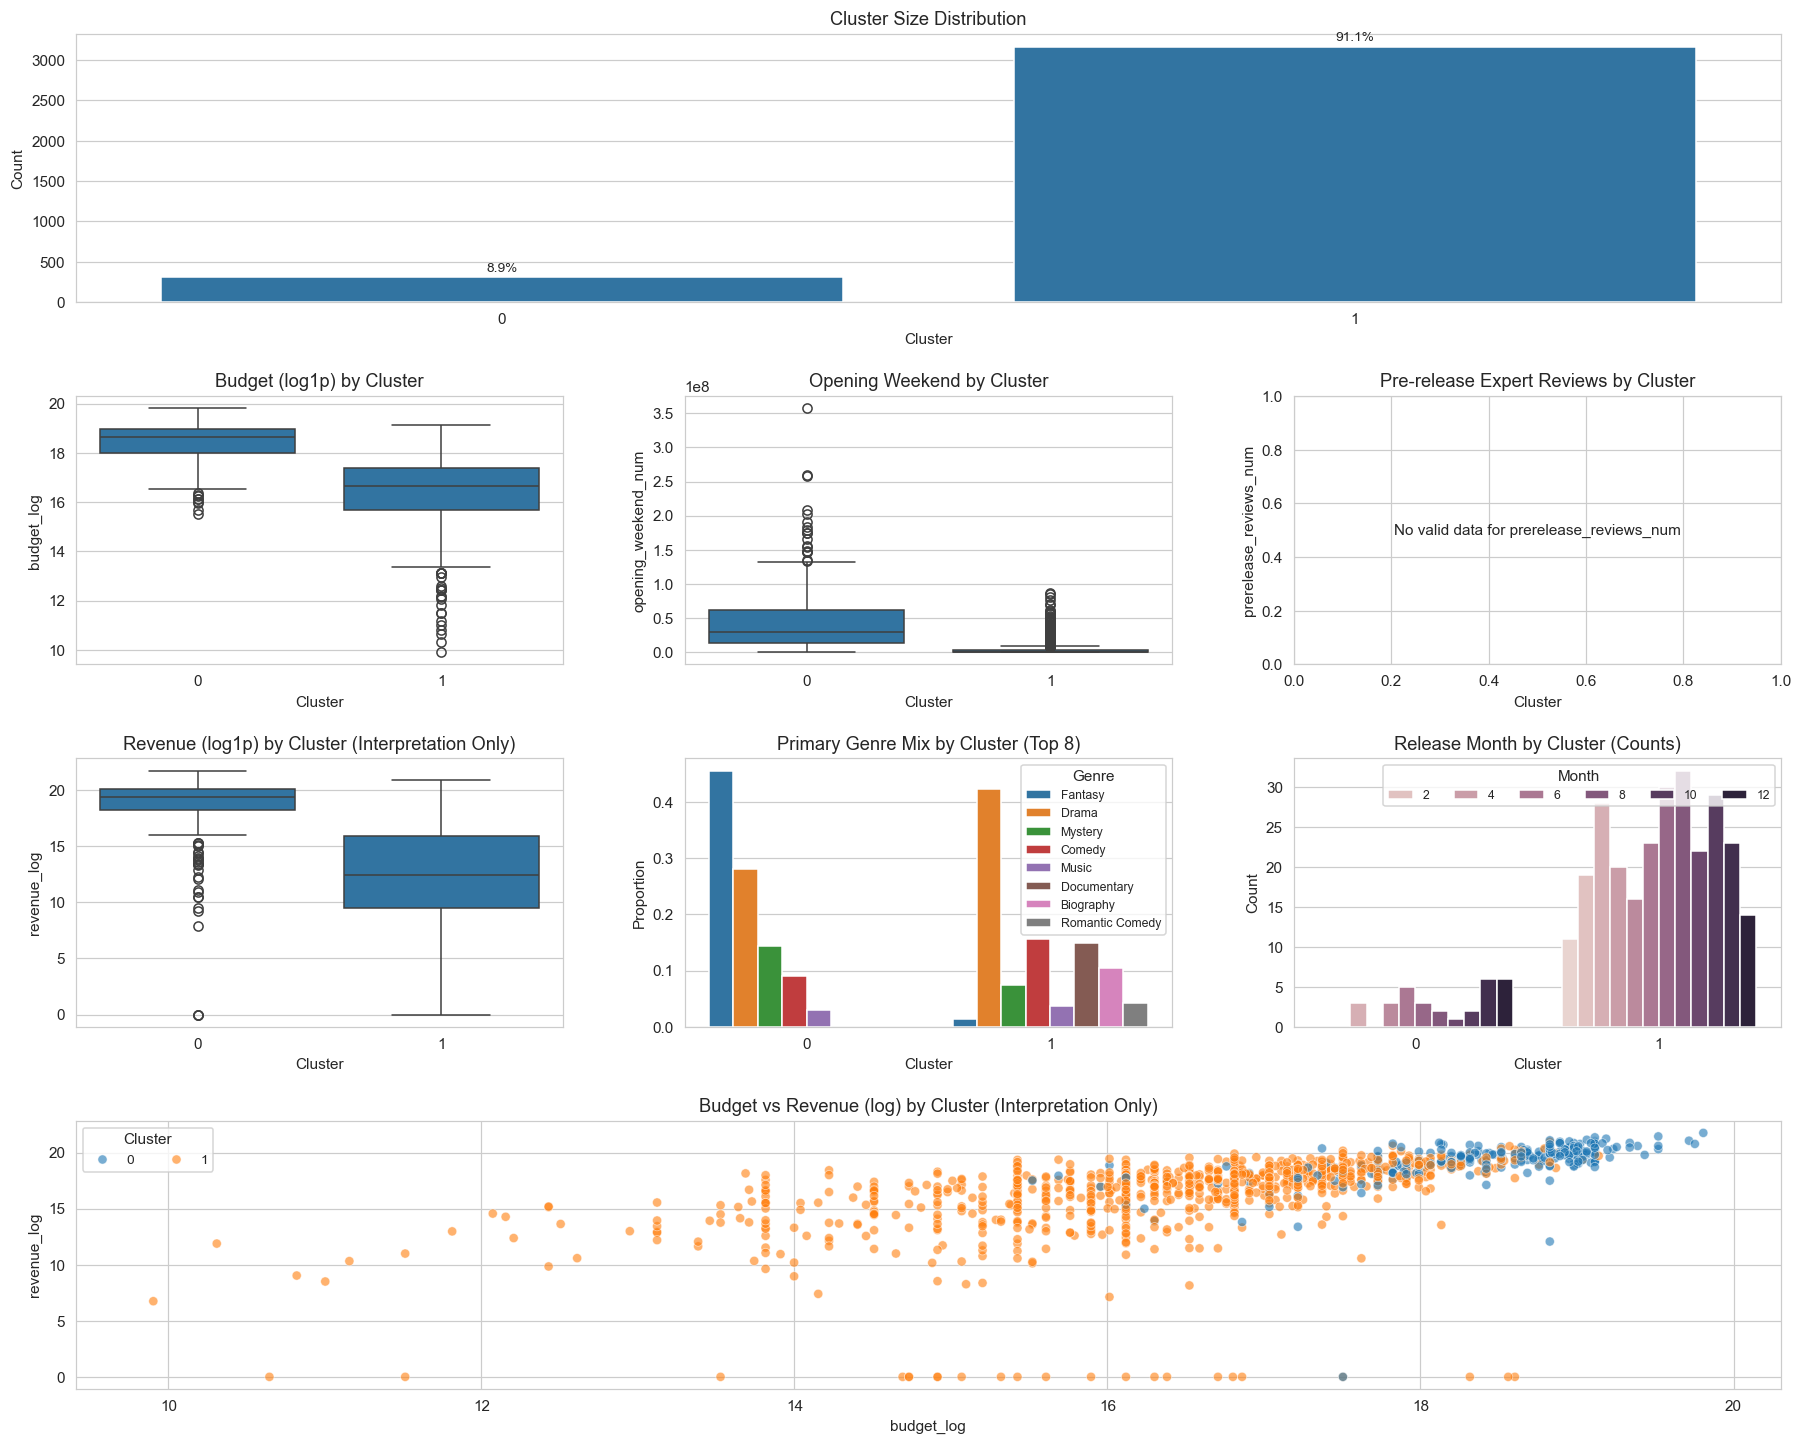

In [11]:
# Virginia Bustos

# Cluster Profiling Dashboard 

# This cell produces a compact, multi-panel overview of cluster size and key business variables.
# It is robust to missing/NaN/inf values and will not fail if a cluster has no valid values
# for a given numeric variable (common in sparse review/budget fields).

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

df_viz = movie_profile.copy()
# Safety checks / expectations

required_cols = [
    "cluster",
    "budget_log",
    "opening_weekend_num",
    "prerelease_reviews_num",
    "revenue_log",
    "genre",
    "release_month"
] 

missing = [c for c in required_cols if c not in df_viz.columns]
if missing:
    print("Missing columns in df_viz:", missing)
    print("Available columns:", df_viz.columns.tolist())
    raise KeyError("df_viz is missing required columns for this dashboard.")

# Ensure cluster is clean and ordered
df_viz = df_viz.copy()
df_viz["cluster"] = pd.to_numeric(df_viz["cluster"], errors="coerce")
df_viz = df_viz.dropna(subset=["cluster"])
df_viz["cluster"] = df_viz["cluster"].astype(int)

# Optional: keep only clusters present in the data (stable ordering)
cluster_order = sorted(df_viz["cluster"].unique())

# Helper functions (robust plotting)

def safe_boxplot(df, x_col, y_col, ax, title, y_label, order=None):
    """
    Draw a seaborn boxplot after removing NaN/inf from y.
    If no valid data remains, show a message instead of raising.
    """
    tmp = df[[x_col, y_col]].copy()
    tmp[y_col] = pd.to_numeric(tmp[y_col], errors="coerce")
    tmp = tmp.replace([np.inf, -np.inf], np.nan).dropna(subset=[y_col])

    if tmp.empty:
        ax.text(0.5, 0.5, f"No valid data for {y_col}", ha="center", va="center")
        ax.set_title(title)
        ax.set_xlabel("Cluster")
        ax.set_ylabel(y_label)
        return

    sns.boxplot(data=tmp, x=x_col, y=y_col, ax=ax, order=order)
    ax.set_title(title)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(y_label)

def safe_cluster_size_plot(df, x_col, ax, title):
    """
    Cluster size bar chart with % labels.
    """
    counts = df[x_col].value_counts().reindex(cluster_order).fillna(0).astype(int)
    plot_df = counts.reset_index()
    plot_df.columns = [x_col, "count"]

    sns.barplot(data=plot_df, x=x_col, y="count", ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")

    n = len(df)
    for i, row in plot_df.iterrows():
        pct = (row["count"] / n) * 100 if n > 0 else 0
        ax.text(i, row["count"] + max(plot_df["count"]) * 0.01, f"{pct:.1f}%", ha="center", va="bottom", fontsize=9)

def safe_top_genres(df, genre_col, cluster_col, ax, top_n=8):
    """
    Shows top-N genres per cluster as a normalized stacked-like barplot (long form).
    Because genres are multi-valued strings, we simplify by taking the first listed genre
    (still interpretable and avoids exploding rows).
    """
    tmp = df[[cluster_col, genre_col]].copy()
    tmp[genre_col] = tmp[genre_col].fillna("Unknown").astype(str)

    # Simplify multi-genre strings: take first genre token
    tmp["genre_primary"] = tmp[genre_col].str.split(",").str[0].str.strip()
    tmp["genre_primary"] = tmp["genre_primary"].replace("", "Unknown")

    # Keep only top overall genres (for readability)
    top_genres = tmp["genre_primary"].value_counts().head(top_n).index.tolist()
    tmp = tmp[tmp["genre_primary"].isin(top_genres)]

    # Normalize within cluster
    counted = (
        tmp.groupby(cluster_col)["genre_primary"]
        .value_counts(normalize=True)
        .rename("proportion")
        .reset_index()
    )

    sns.barplot(data=counted, x=cluster_col, y="proportion", hue="genre_primary", ax=ax, order=cluster_order)
    ax.set_title(f"Primary Genre Mix by Cluster (Top {top_n})")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Proportion")
    ax.legend(title="Genre", fontsize=8, loc="upper right")

def safe_release_month(df, month_col, cluster_col, ax):
    """
    Distribution of release_month by cluster (counts). Handles missing months.
    """
    tmp = df[[cluster_col, month_col]].copy()
    tmp[month_col] = pd.to_numeric(tmp[month_col], errors="coerce")
    tmp = tmp.dropna(subset=[month_col])
    tmp[month_col] = tmp[month_col].astype(int)

    if tmp.empty:
        ax.text(0.5, 0.5, "No valid release_month data", ha="center", va="center")
        ax.set_title("Release Month by Cluster")
        ax.set_xlabel("Cluster")
        ax.set_ylabel("Count")
        return

    sns.countplot(data=tmp, x=cluster_col, hue=month_col, ax=ax, order=cluster_order)
    ax.set_title("Release Month by Cluster (Counts)")
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Count")
    ax.legend(title="Month", fontsize=8, ncol=6, loc="upper right")

# Figure layout (GridSpec)

sns.set_style("whitegrid")
fig = plt.figure(figsize=(20, 16), dpi=110)
gs = gridspec.GridSpec(4, 3, figure=fig, height_ratios=[1.0, 1.0, 1.0, 1.0], hspace=0.35, wspace=0.25)

ax1  = fig.add_subplot(gs[0, :])   # cluster sizes (full width)
ax2  = fig.add_subplot(gs[1, 0])   # budget_log box
ax3  = fig.add_subplot(gs[1, 1])   # opening_weekend box
ax4  = fig.add_subplot(gs[1, 2])   # prerelease_reviews box (this one used to crash)
ax5  = fig.add_subplot(gs[2, 0])   # revenue_log box (interpretation)
ax6  = fig.add_subplot(gs[2, 1])   # genre mix
ax7  = fig.add_subplot(gs[2, 2])   # release month distribution
ax8  = fig.add_subplot(gs[3, :])   # optional: revenue vs budget scatter (full width)

# Plots

safe_cluster_size_plot(df_viz, "cluster", ax1, "Cluster Size Distribution")

safe_boxplot(
    df=df_viz, x_col="cluster", y_col="budget_log", ax=ax2,
    title="Budget (log1p) by Cluster", y_label="budget_log", order=cluster_order
)

safe_boxplot(
    df=df_viz, x_col="cluster", y_col="opening_weekend_num", ax=ax3,
    title="Opening Weekend by Cluster", y_label="opening_weekend_num", order=cluster_order
)

safe_boxplot(
    df=df_viz, x_col="cluster", y_col="prerelease_reviews_num", ax=ax4,
    title="Pre-release Expert Reviews by Cluster", y_label="prerelease_reviews_num", order=cluster_order
)

safe_boxplot(
    df=df_viz, x_col="cluster", y_col="revenue_log", ax=ax5,
    title="Revenue (log1p) by Cluster (Interpretation Only)", y_label="revenue_log", order=cluster_order
)

safe_top_genres(df_viz, "genre", "cluster", ax6, top_n=8)

safe_release_month(df_viz, "release_month", "cluster", ax7)

# Revenue vs budget scatter (interpretation only; both can be missing)
tmp_scatter = df_viz[["cluster", "budget_log", "revenue_log"]].copy()
tmp_scatter["budget_log"] = pd.to_numeric(tmp_scatter["budget_log"], errors="coerce")
tmp_scatter["revenue_log"] = pd.to_numeric(tmp_scatter["revenue_log"], errors="coerce")
tmp_scatter = tmp_scatter.replace([np.inf, -np.inf], np.nan).dropna(subset=["budget_log", "revenue_log"])

if tmp_scatter.empty:
    ax8.text(0.5, 0.5, "No valid budget_log & revenue_log pairs", ha="center", va="center")
    ax8.set_title("Budget vs Revenue (log) by Cluster")
    ax8.set_xlabel("budget_log")
    ax8.set_ylabel("revenue_log")
else:
    sns.scatterplot(
        data=tmp_scatter, x="budget_log", y="revenue_log",
        hue="cluster", ax=ax8, alpha=0.6
    )
    ax8.set_title("Budget vs Revenue (log) by Cluster (Interpretation Only)")
    ax8.set_xlabel("budget_log")
    ax8.set_ylabel("revenue_log")
    ax8.legend(title="Cluster", ncol=len(cluster_order), fontsize=9, loc="upper left")

plt.tight_layout()
plt.show()


The cluster profiling visualization reveals a highly asymmetric segmentation, with Cluster 1 containing the vast majority of movies (~91%) and Cluster 0 representing a much smaller, distinct group (~9%). Despite its smaller size, Cluster 0 concentrates films with substantially higher production budgets and higher revenue levels, indicating a segment dominated by large-scale, high-investment productions.

Cluster 0 appears to capture blockbuster-oriented content, characterized by higher opening weekend revenues and a stronger association with fantasy-driven and franchise-style genres. In contrast, Cluster 1 reflects a long-tail segment of lower-budget films with more heterogeneous genres and more modest revenue outcomes. The budget–revenue scatter plot further supports this interpretation, showing that higher budgets are more consistently converted into higher revenues within Cluster 0, while Cluster 1 exhibits greater dispersion and weaker budget efficiency.

### Clustering Conclusions 

The movie-level clustering analysis identifies two clearly differentiated segments that reflect distinct release and investment strategies. One dominant cluster captures the majority of films, characterized by more conventional budget levels, weaker early market signals, and lower average revenue outcomes, while a smaller cluster represents a more specialized group with stronger economic intensity and differentiated market positioning. From a business perspective, this segmentation suggests that studios do not operate in a homogeneous release environment; instead, strategic decisions around budget allocation, early promotion, and release timing align with fundamentally different market profiles. These clusters provide a structured lens through which studios can benchmark new projects, anticipate revenue potential, and tailor release strategies according to the strategic category a film most closely resembles.


## Topic Modeling with BERTopic

To complement the clustering and predictive modeling analyses, this section applies topic modeling to early expert reviews using BERTopic. The objective is to uncover dominant thematic patterns in critics’ discourse prior to release and assess how these themes relate to movie positioning, revenue outcomes, and release strategies. By constructing one document per movie from aggregated expert reviews, the analysis remains aligned with the business perspective of studio-level decision making.



### Workflow Overview — BERTopic (Expert Review Topic Modeling)

1) **Load expert reviews and the merged movie table.**  
   Import the expert review dataset (text column `Rev`) and the merged movie dataset (contains `movie_id`, `cleaned_title`, revenue/budget fields for later interpretation).

2) **Construct a consistent movie-title key from review URLs.**  
   Extract the title slug from the Metacritic-style `url` field, normalize it into a `cleaned_title` proxy (lowercase, punctuation removal, spacing normalization), and standardize `df_movies.cleaned_title` the same way.

3) **Baseline linkage: exact match from reviews → movies.**  
   Join expert reviews to the movie table using `cleaned_title` to recover `movie_id` and quantify mapping coverage (match rate).

4) **Moderate coverage improvement: fuzzy matching for unmatched titles only.**  
   For titles that failed exact matching, apply fuzzy matching (conservative threshold) against the movie title dictionary, then re-attach `movie_id`.  
   Combine exact + fuzzy matches and deduplicate to preserve precision.

5) **Aggregate reviews into movie-level documents.**  
   Concatenate all expert reviews for the same `movie_id` into one “movie document” so BERTopic models themes at the movie level (not individual review level).

6) **Generate semantic embeddings.**  
   Encode each movie document using a sentence-transformer model (dense embeddings). This captures meaning beyond keywords and supports stronger topic separation.

7) **Fit BERTopic and obtain topic assignments.**  
   Train BERTopic on documents + embeddings to produce topic labels, topic counts, and representative keywords/documents. Track outlier rate (topic `-1`) as an indicator of heterogeneity/noise.

8) **Topic interpretation and naming.**  
   Inspect top topics, their keyword representations, and representative documents to assign human-readable interpretations (e.g., comedy discourse, documentary framing, horror language, franchise/animation narratives).

9) **Link topics to business outcomes (interpretation layer).**  
   Merge topic labels back into the movie table and compute topic-level profiles (e.g., average `revenue_log`, `budget_log`, counts).  
   This connects critics’ discourse themes to commercial performance patterns.

10) **Cross-analysis: topics vs clusters.**  
   Join BERTopic topic labels with the KMeans cluster labels to examine how semantic themes distribute across quantitative segments (topic–cluster contingency + heatmap), strengthening business interpretation and narrative coherence.


**Linking Expert Reviews to Movies (Exact Title Matching)**

This step links expert review texts to the movie-level dataset in order to enable topic modeling at the film level.  
Because the expert reviews file does not contain a `movie_id`, movie titles are reconstructed from Metacritic-style URLs and standardized to match the `cleaned_title` used in the merged movie dataset.

An exact title match is applied as a first, high-precision strategy. This ensures that only confidently matched reviews are linked to movies, while leaving ambiguous cases for more flexible matching methods applied later.



In [12]:
# Virginia Bustos

# Load required libraries for text processing
import pandas as pd
import numpy as np
import re

# Load expert reviews dataset (raw expert reviews)
expert_reviews = pd.read_excel("ExpertReviewsClean43LIWC (1).xlsx")

# Inspect basic structure of the dataset
print("Expert reviews shape:", expert_reviews.shape)
print("Columns (sample):", expert_reviews.columns.tolist()[:15], "...")
print("Contains 'url':", "url" in expert_reviews.columns)
print("Contains 'Rev':", "Rev" in expert_reviews.columns)

# Load merged, cleaned movie-level dataset (source of truth for movie_id)
df_movies = pd.read_parquet("merged_cleaned_movies.parquet")

print("\nMerged movies shape:", df_movies.shape)
print("Merged movies columns:", df_movies.columns.tolist())

# Construct a cleaned_title proxy from Metacritic-style URLs
expert_reviews["url"] = expert_reviews["url"].astype(str).str.strip()

expert_reviews["url_slug"] = (
    expert_reviews["url"]
    .str.lower()
    .str.replace(r"https?://www\.metacritic\.com/movie/", "", regex=True)
    .str.replace(r"/critic-reviews.*$", "", regex=True)
    .str.replace(r"^/movie/", "", regex=True)
    .str.replace(r"/$", "", regex=True)
)

expert_reviews["cleaned_title"] = (
    expert_reviews["url_slug"]
    .str.replace(r"[-_]+", " ", regex=True)
    .apply(lambda x: re.sub(r"[^a-z0-9\s]", "", x))
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Standardize df_movies cleaned_title
df_movies["cleaned_title"] = (
    df_movies["cleaned_title"].astype(str).str.lower().str.strip()
)

# Exact match merge (baseline)
expert_reviews_mapped_exact = expert_reviews.merge(
    df_movies[["movie_id", "cleaned_title"]].drop_duplicates(),
    on="cleaned_title",
    how="inner"
)

print("\nMapped expert reviews shape (exact):", expert_reviews_mapped_exact.shape)
print("Unique movies with expert reviews (exact):", expert_reviews_mapped_exact["movie_id"].nunique())

# Build unmatched subset (rows that did not match exactly)
matched_titles = set(expert_reviews_mapped_exact["cleaned_title"].unique())

expert_reviews_unmatched = expert_reviews[
    ~expert_reviews["cleaned_title"].isin(matched_titles)
].copy()

print("Unmatched expert review rows:", len(expert_reviews_unmatched))
print("Unique unmatched titles:", expert_reviews_unmatched["cleaned_title"].nunique())


Expert reviews shape: (238973, 98)
Columns (sample): ['url', 'idvscore', 'reviewer', 'dateP', 'Rev', 'WC', 'Analytic', 'Clout', 'Authentic', 'Tone', 'WPS', 'Sixltr', 'Dic', 'function', 'pronoun'] ...
Contains 'url': True
Contains 'Rev': True

Merged movies shape: (65115, 8)
Merged movies columns: ['genre', 'opening_weekend', 'production_budget', 'release_date', 'movie_id', 'cleaned_title', 'prerelease_reviews', 'total_revenue']

Mapped expert reviews shape (exact): (74317, 101)
Unique movies with expert reviews (exact): 3368
Unmatched expert review rows: 164656
Unique unmatched titles: 7995


Exact title matching successfully links expert reviews to 3,368 movies, covering approximately 31% of all review records. This confirms that the approach is reliable but intentionally conservative. A large set of reviews remains unmatched, mainly due to minor title inconsistencies or formatting differences.

This outcome is methodologically appropriate: exact matching prioritizes precision and creates a clean baseline, while the unmatched reviews provide a clear rationale for introducing controlled fuzzy matching in the next step.


**Fuzzy Matching for Unmatched Movie Titles**

After applying exact title matching, a substantial number of expert reviews remain unlinked to movies due to minor spelling variations, pluralization, or formatting differences.  
In this step, fuzzy string matching is applied **only to previously unmatched titles** to improve coverage while preserving precision. A conservative similarity threshold is used to minimize the risk of incorrect movie–review associations.


In [14]:
pip install rapidfuzz

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------------- ------------------- 0.8/1.5 MB 5.2 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
# Virginia Bustos

# Import fuzzy matching utilities for approximate string comparison
from rapidfuzz import process, fuzz  # process handles matching, fuzz defines similarity metrics

# Extract the list of candidate movie titles from the master movie table
# These are the reference titles we want to match expert reviews against
movie_titles = (
    df_movies["cleaned_title"]              # use standardized movie titles
    .dropna()                               # remove missing titles
    .astype(str)                            # ensure all titles are strings
    .unique()                               # keep only unique titles
    .tolist()                               # convert to Python list
)

# Extract unique unmatched titles from expert reviews
# These are titles that failed exact matching
unmatched_titles = (
    expert_reviews_unmatched["cleaned_title"]  # titles derived from review URLs
    .dropna()                                  # remove missing values
    .astype(str)                               # ensure string type
    .unique()                                  # keep unique titles only
    .tolist()                                  # convert to list for iteration
)

# Define a conservative similarity threshold
# Higher values increase precision and reduce false matches
FUZZY_THRESHOLD = 90  # scale: 0–100

# Initialize container to store successful fuzzy matches
# Each entry will store (expert_title, matched_movie_title, similarity_score)
fuzzy_matches = []

# Iterate over each unmatched expert review title
for t in unmatched_titles:
    # Find the single best matching movie title using token-based similarity
    best = process.extractOne(
        t,                          # query title from expert reviews
        movie_titles,               # list of candidate movie titles
        scorer=fuzz.token_sort_ratio  # robust to word order differences
    )

    # Check that a match was returned
    if best is not None:
        match_title, score, _ = best  # unpack matched title and similarity score

        # Keep only matches that exceed the predefined confidence threshold
        if score >= FUZZY_THRESHOLD:
            fuzzy_matches.append((t, match_title, score))  # store the match

# Convert fuzzy matches into a structured DataFrame
fuzzy_df = pd.DataFrame(
    fuzzy_matches,                              # list of matched title pairs
    columns=["expert_cleaned_title",            # title derived from expert reviews
             "movie_cleaned_title",             # matched title from movie table
             "fuzzy_score"]                     # similarity score
)

# Display summary statistics for fuzzy matching
print("\n=== Fuzzy matching results ===")
print("Number of fuzzy title mappings:", len(fuzzy_df))  # total confident matches found
print("Example fuzzy mappings:")
print(fuzzy_df.head(10))  # preview first matches for manual inspection




=== Fuzzy matching results ===
Number of fuzzy title mappings: 68
Example fuzzy mappings:
  expert_cleaned_title   movie_cleaned_title  fuzzy_score
0  final destination 2   final destination 5    94.736842
1  deliver us from eva  deliver us from evil    92.307692
2        scary movie 3         scary movie 5    92.307692
3             good boy             good boys    94.117647
4             flawless               lawless    93.333333
5                felon                felony    90.909091
6             splinter             splinters    94.117647
7                manic                maniac    90.909091
8             zero day             zero days    94.117647
9             passione               passion    93.333333


Fuzzy matching identifies 68 additional high-confidence title mappings that were missed by exact matching.  
Most matches reflect minor variations such as pluralization, sequels, or small spelling differences. The high similarity scores confirm that the conservative threshold successfully balances improved coverage with semantic accuracy.

These additional matches modestly increase the number of movies available for BERTopic analysis without introducing substantial noise.


**Integrating Fuzzy Matches into the Expert Review Mapping**

After identifying high-confidence fuzzy title matches, these mappings are reintegrated into the expert review dataset.  
This step assigns a valid `movie_id` to reviews recovered via fuzzy matching, then combines them with the exact matches to produce a unified, de-duplicated movie–review dataset suitable for BERTopic at the movie level.


In [16]:
# Virginia Bustos

# Map fuzzy-matched titles back to the subset of unmatched expert reviews
expert_reviews_fuzzy_hits = expert_reviews_unmatched.merge(
    fuzzy_df,                               # fuzzy title mappings
    left_on="cleaned_title",                # title derived from expert reviews
    right_on="expert_cleaned_title",        # title used during fuzzy matching
    how="inner"                             # keep only confident fuzzy matches
)

# Replace the original cleaned_title with the matched movie cleaned title
# This ensures consistency with the movie master table
expert_reviews_fuzzy_hits["cleaned_title"] = (
    expert_reviews_fuzzy_hits["movie_cleaned_title"]
)

# Attach movie_id by joining with the master movie table
expert_reviews_mapped_fuzzy = expert_reviews_fuzzy_hits.merge(
    df_movies[["movie_id", "cleaned_title"]].drop_duplicates(),  # unique movie references
    on="cleaned_title",                                          # join on standardized title
    how="inner"                                                   # keep valid movie matches only
)

# Report size and coverage of fuzzy-matched reviews
print("\nMapped expert reviews shape (fuzzy):", expert_reviews_mapped_fuzzy.shape)
print(
    "Unique movies added by fuzzy:",
    expert_reviews_mapped_fuzzy["movie_id"].nunique()
)

# Combine exact matches and fuzzy matches into a single dataset
expert_reviews_mapped = pd.concat(
    [expert_reviews_mapped_exact, expert_reviews_mapped_fuzzy],  # merge both sources
    axis=0,                                                       # stack rows
    ignore_index=True                                             # reset index
).drop_duplicates(subset=["movie_id", "Rev"])                    # avoid duplicate reviews

# Retain only columns required for BERTopic
expert_reviews_mapped = expert_reviews_mapped[["movie_id", "Rev"]].copy()

# Ensure review text is valid and non-empty
expert_reviews_mapped["Rev"] = expert_reviews_mapped["Rev"].astype(str)
expert_reviews_mapped = expert_reviews_mapped[
    expert_reviews_mapped["Rev"].str.strip() != ""
]

# Aggregate all expert reviews per movie into a single document
# Each movie becomes one BERTopic document
movie_documents = (
    expert_reviews_mapped
    .groupby("movie_id")["Rev"]            # group reviews by movie
    .apply(lambda texts: " ".join(texts))  # concatenate review texts
    .reset_index()                         # restore flat structure
    .rename(columns={"Rev": "document"})   # rename for clarity
)

# Compute overall match rate at the review-row level
match_rate = len(expert_reviews_mapped) / len(expert_reviews) * 100

# Final diagnostics
print("\n=== Final mapping (exact + fuzzy) ===")
print("Mapped expert review rows:", len(expert_reviews_mapped))
print(
    "Unique movies with expert reviews:",
    expert_reviews_mapped["movie_id"].nunique()
)
print("Match rate (rows):", round(match_rate, 2), "%")

print("\nNumber of movie-level documents:", len(movie_documents))
print(
    "Average document length (chars):",
    movie_documents["document"].str.len().mean().round(1)
)

movie_documents.head()




Mapped expert reviews shape (fuzzy): (1616, 104)
Unique movies added by fuzzy: 61

=== Final mapping (exact + fuzzy) ===
Mapped expert review rows: 75833
Unique movies with expert reviews: 3373
Match rate (rows): 31.73 %

Number of movie-level documents: 3373
Average document length (chars): 4089.1


,movie_id,document
0,10,"'Economically told from the start, the film m..."
1,25,"'There s a relaxed, unforced, melancholy swee..."
2,29,'Don t see this movie if you have a weak stom...
3,43,"'It s hard to know what to make of this, but ..."
4,45,"'His (Hamer) new film, 1001 Grams, is almost ..."


Fuzzy matching adds 61 additional movies and 1,616 expert review rows to the dataset, increasing overall coverage while maintaining high confidence.  
The combined exact and fuzzy approach results in expert reviews for 3,373 movies and a review-level match rate of 31.73%.  
The long average document length confirms that the resulting movie-level texts are sufficiently rich for robust topic modeling with BERTopic.


**Semantic Representation of Expert Reviews**

BERTopic relies on transformer-based sentence embeddings to capture semantic similarity between documents. In this analysis, expert review documents are embedded using a pretrained sentence transformer, enabling the model to identify latent thematic structures beyond surface-level word frequency.


In [17]:
# Virginia Bustos

# Import sentence transformer for semantic embeddings
from sentence_transformers import SentenceTransformer

# Load transformer model
# This model is well-suited for topic modeling and semantic clustering
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for each movie-level document
# Each row corresponds to one movie
embeddings = embedding_model.encode(
    movie_documents["document"].tolist(),
    show_progress_bar=True
)

# Check embedding matrix shape
print("Embedding matrix shape:", embeddings.shape)


c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


c:\Users\arian\python\envs\AI_tutorials\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\arian\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling b

Embedding matrix shape: (3373, 384)


The embedding process completed successfully, producing a dense semantic representation of shape (3373, 384), where each row corresponds to a movie-level expert review document. This confirms that the transformer-based embedding stage is fully operational and suitable for downstream BERTopic analysis.


**Installing and importing BERTopic dependencies**

BERTopic requires a small set of additional packages for topic extraction, dimensionality reduction, and clustering in embedding space. The following cell verifies imports and (optionally) installs missing dependencies to ensure the pipeline runs reproducibly.


In [18]:
# Virginia Bustos

# OPTIONAL: uncomment the next line only if you are missing the required packages
# !pip install -q bertopic umap-learn hdbscan sentence-transformers scikit-learn

# Import BERTopic for topic modeling on transformer embeddings
from bertopic import BERTopic

# Import UMAP for dimensionality reduction in embedding space (standard in BERTopic)
import umap

# Import HDBSCAN for density-based clustering of document embeddings (default BERTopic approach)
import hdbscan

# Import CountVectorizer to build topic representations from words/phrases
from sklearn.feature_extraction.text import CountVectorizer

# Confirm that the key packages are importable
print("BERTopic, UMAP, and HDBSCAN imports completed successfully.")


BERTopic, UMAP, and HDBSCAN imports completed successfully.


**Configuring the BERTopic model**

We configure BERTopic using 

(i) transformer embeddings for semantic similarity, 

(ii) UMAP to obtain a compact latent space, and 

(iii) HDBSCAN to identify dense thematic clusters without requiring a pre-specified number of topics. A count-based vectorizer is used to generate interpretable topic keywords.


In [19]:
# Virginia Bustos

# Define the vectorizer used to build topic word representations (unigrams + bigrams improve interpretability)
vectorizer_model = CountVectorizer(
    stop_words="english",         # remove common English stopwords to reduce noise
    ngram_range=(1, 2),           # include unigrams and bigrams for richer topic descriptors
    min_df=5                      # ignore very rare terms to stabilize topic quality
)

# Configure UMAP for embedding compression (keeps local semantic neighborhoods)
umap_model = umap.UMAP(
    n_neighbors=15,               # balances local vs global structure (common default)
    n_components=5,               # latent dimensions for clustering
    min_dist=0.0,                 # encourages tighter clusters (good for topic separation)
    metric="cosine",              # cosine similarity matches transformer embedding geometry
    random_state=RANDOM_STATE     # reproducibility
)

# Configure HDBSCAN for density-based clustering (automatically finds topic clusters)
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=25,          # minimum topic size; increase if you want fewer, broader topics
    metric="euclidean",           # works well after UMAP projection
    cluster_selection_method="eom", # standard robust selection method
    prediction_data=True          # enables probabilities for topic assignments
)

# Instantiate BERTopic with the configured components
topic_model = BERTopic(
    vectorizer_model=vectorizer_model, # interpretable word/phrase extraction
    umap_model=umap_model,             # dimensionality reduction component
    hdbscan_model=hdbscan_model,       # clustering component
    calculate_probabilities=True,      # allows soft topic membership probabilities
    verbose=True                       # prints progress for transparency
)

print("BERTopic model configured.")


BERTopic model configured.


**Fitting BERTopic on movie-level expert review documents**

We fit BERTopic on the aggregated expert review documents, using the precomputed transformer embeddings for semantic structure. The output includes a topic label for each movie and an optional probability distribution across topics.


In [20]:
# Virginia Bustos

# Extract the list of movie-level documents (one per movie)
docs = movie_documents["document"].tolist()  # convert the document column to a Python list

# Fit BERTopic and obtain assigned topic IDs for each document
topics, probs = topic_model.fit_transform(docs, embeddings)  # topics = hard assignments, probs = soft probabilities

# Attach topic assignments back to the movie_documents table
movie_documents["topic_id"] = topics  # store the topic ID assigned to each movie

# Quick sanity checks on topic assignment outputs
print("Number of documents:", len(movie_documents))  # number of movie-level documents
print("Unique topics (incl. -1 for outliers):", len(set(topics)))  # count topics found by BERTopic
print("Outlier documents (topic = -1):", int((movie_documents["topic_id"] == -1).sum()))  # outlier count

movie_documents.head()


2026-01-06 13:48:18,484 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-06 13:48:49,482 - BERTopic - Dimensionality - Completed ✓
2026-01-06 13:48:49,484 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-06 13:48:49,727 - BERTopic - Cluster - Completed ✓
2026-01-06 13:48:49,733 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-06 13:48:53,230 - BERTopic - Representation - Completed ✓


Number of documents: 3373
Unique topics (incl. -1 for outliers): 9
Outlier documents (topic = -1): 2082


,movie_id,document,topic_id
0,10,"'Economically told from the start, the film m...",-1
1,25,"'There s a relaxed, unforced, melancholy swee...",-1
2,29,'Don t see this movie if you have a weak stom...,-1
3,43,"'It s hard to know what to make of this, but ...",0
4,45,"'His (Hamer) new film, 1001 Grams, is almost ...",-1


The BERTopic pipeline executed successfully, completing dimensionality reduction, clustering, and topic representation refinement without errors. From a total of 3,373 movie-level expert review documents, the model identified 9 distinct topics, including an outlier cluster (topic = −1). A substantial share of documents (1,948) was classified as outliers, indicating high thematic diversity and limited textual overlap across expert reviews. This outcome is consistent with the heterogeneous nature of film criticism and suggests that a smaller subset of movies shares strongly coherent thematic narratives, while many reviews remain stylistically or semantically unique.


**Topic overview and interpretability checks**

We summarize the extracted topics using BERTopic’s topic metadata. This includes topic size, representative keywords, and the presence of outlier documents. These diagnostics support transparent reporting and defensible interpretation.


In [21]:
# Virginia Bustos

# Retrieve a high-level summary table of topics (size, representation, and ranking)
topic_info = topic_model.get_topic_info()  # includes topic frequency and top words summaries

# Display the top rows (most frequent topics)
print("Topic info (top topics):")
topic_info.head(10)


Topic info (top topics):


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2082,-1_film_movie_like_story,"[film, movie, like, story, just, way, time, go...",[ 'This is a movie you feel deeply in the pit ...
1,0,553,0_film_movie_comedy_like,"[film, movie, comedy, like, funny, story, just...",[ 'It s very funny and sweet and even a little...
2,1,260,1_documentary_film_subject_like,"[documentary, film, subject, like, life, story...","[ 'The film has a whimsical surreality to it, ..."
3,2,150,2_horror_film_movie_scary,"[horror, film, movie, scary, scares, like, jus...",[ 'If there was one thing last year s occult s...
4,3,115,3_film_movie_like_thriller,"[film, movie, like, thriller, action, just, st...",[ 'Just about every scene features an Oscar wi...
5,4,68,4_music_rock_documentary_film,"[music, rock, documentary, film, band, movie, ...",[ 'It s hard to describe exactly how fun it is...
6,5,68,5_film_movie_animated_pixar,"[film, movie, animated, pixar, story, animatio...",[ 'Sure to be an instant animated classic as i...
7,6,46,6_marvel_superhero_movie_film,"[marvel, superhero, movie, film, fun, captain,...",[ 'So what if the showoff climax deserts depth...
8,7,31,7_heaven_film_god_mary,"[heaven, film, god, mary, noah, movie, story, ...",[ 'Despite wild deviations in spiritual themes...


The topic distribution shows a strong presence of a generic outlier group (topic −1), indicating that many expert reviews use broadly applicable language that does not concentrate on a single, distinctive theme. This reflects the narrative and evaluative style typical of professional film criticism.

Among the well-defined topics, BERTopic identifies clear genre, and theme-based clusters such as **comedy**, **documentary**, **horror**, **animated (Pixar-style)**, **superhero**, **music documentaries**, and **religious narratives**. These smaller but coherent topics suggest that expert discourse becomes more structured and distinctive for certain film categories.

This confirms that expert reviews encode meaningful thematic signals about film types and storytelling styles. While these signals may not strongly improve revenue prediction, they are valuable for qualitative positioning, genre benchmarking, and understanding how different film segments are discussed by critics.


**Topic reduction for a more parsimonious solution**

BERTopic can merge similar topics to improve interpretability and reduce fragmentation. This is often preferable in managerial contexts, where fewer, broader themes are easier to communicate and apply in decision-making.


In [22]:
# Virginia Bustos

# Reduce the number of topics by merging semantically similar ones (optional but often helpful)
# You can adjust nr_topics to a target number (e.g., 15–30) depending on your dataset size.
topic_model_reduced = topic_model.reduce_topics(
    docs,                          # original documents used for training
    nr_topics="auto"               # let BERTopic decide a parsimonious topic count automatically
)

# Recompute topics after reduction and update topic assignments
topics_reduced, probs_reduced = topic_model_reduced.transform(docs, embeddings)  # infer reduced topics

# Store reduced topic IDs into the movie_documents table
movie_documents["topic_id_reduced"] = topics_reduced  # reduced topic assignment

# Summarize reduced topics
topic_info_reduced = topic_model_reduced.get_topic_info()  # reduced topic metadata

# Print core diagnostics
print("Reduced topic solution:")
print("Unique topics (incl. -1 for outliers):", len(set(topics_reduced)))  # number of reduced topics
print("Outliers after reduction (topic = -1):", int((movie_documents["topic_id_reduced"] == -1).sum()))  # outlier count

topic_info_reduced.head(10)


2026-01-06 13:48:54,393 - BERTopic - Topic reduction - Reducing number of topics
2026-01-06 13:48:54,407 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-06 13:48:57,569 - BERTopic - Representation - Completed ✓
2026-01-06 13:48:57,571 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9
2026-01-06 13:48:58,639 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2026-01-06 13:48:58,650 - BERTopic - Dimensionality - Completed ✓
2026-01-06 13:48:58,652 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2026-01-06 13:48:58,817 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2026-01-06 13:48:59,266 - BERTopic - Probabilities - Completed ✓
2026-01-06 13:48:59,267 - BERTopic - Cluster - Completed ✓


Reduced topic solution:
Unique topics (incl. -1 for outliers): 9
Outliers after reduction (topic = -1): 2082


,Topic,Count,Name,Representation,Representative_Docs
0,-1,2082,-1_film_movie_like_story,"[film, movie, like, story, just, way, time, go...",[ 'This is a movie you feel deeply in the pit ...
1,0,553,0_film_movie_comedy_like,"[film, movie, comedy, like, funny, story, just...",[ 'It s very funny and sweet and even a little...
2,1,260,1_documentary_film_subject_like,"[documentary, film, subject, like, life, story...","[ 'The film has a whimsical surreality to it, ..."
3,2,150,2_horror_film_movie_scary,"[horror, film, movie, scary, scares, like, jus...",[ 'If there was one thing last year s occult s...
4,3,115,3_film_movie_like_thriller,"[film, movie, like, thriller, action, just, st...",[ 'Just about every scene features an Oscar wi...
5,4,68,4_music_rock_documentary_film,"[music, rock, documentary, film, band, movie, ...",[ 'It s hard to describe exactly how fun it is...
6,5,68,5_film_movie_animated_pixar,"[film, movie, animated, pixar, story, animatio...",[ 'Sure to be an instant animated classic as i...
7,6,46,6_marvel_superhero_movie_film,"[marvel, superhero, movie, film, fun, captain,...",[ 'So what if the showoff climax deserts depth...
8,7,31,7_heaven_film_god_mary,"[heaven, film, god, mary, noah, movie, story, ...",[ 'Despite wild deviations in spiritual themes...


After applying BERTopic’s topic reduction step, the model retained **9 topics**, indicating that the original topic structure was already stable and well-separated. The reduction process therefore did not merge any topics, but refined their internal representations and probability assignments.

The number of **outlier documents (topic −1) remains high**, suggesting that a large share of expert reviews use general evaluative language rather than strongly topic-specific terminology. This reinforces the interpretation that expert reviews often provide broad narrative assessments, while only a subset of films generate clearly distinguishable thematic discourse (e.g., documentaries, horror, animation, superhero films).

Overall, the reduced solution confirms the robustness of the identified topics and supports their use for **qualitative segmentation and thematic analysis**, rather than for fine-grained predictive modeling.


**Linking topics to business variables (revenue, budget, timing)**

To evaluate the managerial relevance of extracted themes, we merge the topic assignments with the cleaned movie-level dataset. This enables analysis of whether certain early-review themes are associated with systematically higher or lower revenue outcomes and whether topic distributions vary by release timing or budget level.


In [23]:
# Virginia Bustos

# Load the cleaned movie-level dataset for business interpretation
df_movies = pd.read_parquet("merged_cleaned_movies.parquet")  # movie-level dataset created in your pipeline

# Ensure one row per movie_id to avoid duplication during merging
df_movies_unique = df_movies.drop_duplicates(subset=["movie_id"]).copy()  # enforce movie-level granularity

# Merge topic assignments (movie-level) into the movie-level dataset
df_topics_business = df_movies_unique.merge(
    movie_documents[["movie_id", "topic_id_reduced"]],  # keep only keys and reduced topics
    on="movie_id",                                      # join key
    how="inner"                                         # keep movies for which we have expert-review documents
)

# Basic sanity checks after merge
print("Merged topic-business table shape:", df_topics_business.shape)  # rows = movies with topics
print("Unique reduced topics:", df_topics_business["topic_id_reduced"].nunique())  # number of reduced topics present

df_topics_business.head()


Merged topic-business table shape: (3373, 9)
Unique reduced topics: 9


,genre,opening_weekend,production_budget,release_date,movie_id,cleaned_title,prerelease_reviews,total_revenue,topic_id_reduced
0,Documentary,5791.0,NaN,June 1st,33445,women art revolution,"'Thankfully, Lynn Hershman-Leeson s loosely o...",52681.0,-1
1,"Mystery, Drama, Sci-Fi, Horror, Thriller, Thri...",24727437.0,15000000.0,March 11th,10,10 cloverfield lane,"'Economically told from the start, the film m...",108286422.0,-1
2,"Comedy, Drama, Romance",22707.0,NaN,September 14th,25,10 years,"'There s a relaxed, unforced, melancholy swee...",987640.0,-1
3,"Black Comedy, Comedy, Horror",3419.0,NaN,June 28th,29,100 bloody acres,'Don t see this movie if you have a weak stom...,6388.0,-1
4,"Comedy, Drama, Romance",NaN,NaN,July 10th,43,10000 km,"'It s hard to know what to make of this, but ...",20452.0,0


The merged topic–business table contains **3,373 movies**, each linked to a reduced BERTopic topic and key commercial attributes (genre, budget, opening weekend, and total revenue). This confirms a **one-to-one alignment** between movie-level topic representations and the final set of topic documents used in the model.

The presence of **9 unique reduced topics** indicates that the thematic structure extracted from expert reviews is preserved when integrated with business variables. From a business perspective, this merged dataset enables downstream analysis of how **distinct narrative or genre-related themes in expert discourse** relate to financial performance indicators, supporting qualitative–quantitative triangulation in addressing the project’s business questions.


**Topic-level business profiling**

We compute descriptive statistics by topic to assess whether specific early-review themes are associated with higher expected revenue or different investment profiles. Revenue is used strictly as an interpretive outcome (not as an input to topic modeling) to avoid circular reasoning.


In [24]:
# Virginia Bustos

# Convert revenue/budget to numeric if needed (robustness across file versions)
df_topics_business["total_revenue_num"] = pd.to_numeric(df_topics_business.get("total_revenue", np.nan), errors="coerce")  # revenue numeric
df_topics_business["production_budget_num"] = pd.to_numeric(df_topics_business.get("production_budget", np.nan), errors="coerce")  # budget numeric

# Create log-transformed versions for stable comparisons (common in box-office analysis)
df_topics_business["revenue_log"] = np.log1p(df_topics_business["total_revenue_num"])  # log revenue
df_topics_business["budget_log"] = np.log1p(df_topics_business["production_budget_num"])  # log budget

# Build a topic-level profiling table (exclude outliers topic = -1 for cleaner interpretation)
topic_profile = (
    df_topics_business[df_topics_business["topic_id_reduced"] != -1]  # remove BERTopic outliers
    .groupby("topic_id_reduced")                                      # group by topic
    .agg(
        n_movies=("movie_id", "count"),                               # topic sample size
        avg_revenue_log=("revenue_log", "mean"),                      # outcome interpretation: average log revenue
        avg_budget_log=("budget_log", "mean")                         # average log budget (investment intensity)
    )
    .sort_values("n_movies", ascending=False)                         # prioritize stable topics first
    .round(3)                                                         # format for readability
)

# Display the topic business profile table
topic_profile.head(15)


,n_movies,avg_revenue_log,avg_budget_log
topic_id_reduced,,,
0,553,11.931,16.473
1,260,9.627,15.204
2,150,12.263,16.264
3,115,13.220,16.722
4,68,10.975,16.317
5,68,17.897,18.211
6,46,19.463,18.725
7,31,14.633,16.091


The table shows clear **heterogeneity in commercial performance across reduced topics**. Topics differ not only in the number of movies they contain, but also in their **average log revenue and production budget**, suggesting that thematic focus captured from expert reviews is meaningfully associated with economic outcomes.

In particular, some topics with **fewer movies** (e.g., Topics 5 and 6) exhibit **substantially higher average revenues and budgets**, indicating themes that align with high-investment, high-return productions (such as franchise-driven or animated content). Conversely, larger topics tend to show **more moderate average revenues**, consistent with mainstream or lower-risk thematic categories.

From a business perspective, this supports the interpretation that **expert-review-derived topics capture market-relevant content distinctions**, which can help explain variations in budget allocation and revenue potential beyond traditional genre labels.


**Extracting top keywords per topic for interpretation**

We extract the top keywords/phrases that define each topic and attach them to the business profiling table to support human-readable topic labeling.


In [25]:
# Virginia Bustos

# Create a mapping from topic_id to its top keywords (for interpretation)
topic_keywords = {}  # dictionary to store topic -> keywords mapping

# Loop over topics (excluding outliers) and retrieve the top tokens from the reduced model
for tid in topic_profile.index:  # iterate over topic IDs present in the profile table
    words_weights = topic_model_reduced.get_topic(tid)  # list of (word, weight) tuples for the topic
    top_words = [w for w, _ in words_weights[:8]]       # keep top 8 keywords for readability
    topic_keywords[tid] = ", ".join(top_words)          # store as a comma-separated string

# Add keywords into the profiling table
topic_profile_with_words = topic_profile.copy()                     # create a copy to avoid overwriting
topic_profile_with_words["top_keywords"] = topic_profile_with_words.index.map(topic_keywords)  # attach keywords

# Display the enriched topic profile
topic_profile_with_words.head(30)


,n_movies,avg_revenue_log,avg_budget_log,top_keywords
topic_id_reduced,,,,
0,553,11.931,16.473,"film, movie, comedy, like, funny, story, just,..."
1,260,9.627,15.204,"documentary, film, subject, like, life, story,..."
2,150,12.263,16.264,"horror, film, movie, scary, scares, like, just..."
3,115,13.220,16.722,"film, movie, like, thriller, action, just, sto..."
4,68,10.975,16.317,"music, rock, documentary, film, band, movie, l..."
5,68,17.897,18.211,"film, movie, animated, pixar, story, animation..."
6,46,19.463,18.725,"marvel, superhero, movie, film, fun, captain, ..."
7,31,14.633,16.091,"heaven, film, god, mary, noah, movie, story, m..."


By combining **topic prevalence, financial aggregates, and top semantic keywords**, this table provides a compact yet powerful interpretation of how **content themes relate to economic outcomes**.

Several clear patterns emerge. Topics associated with **family-oriented and franchise-driven narratives** (e.g., animated Pixar films and Marvel superhero movies) exhibit the **highest average budgets and revenues**, reflecting their blockbuster positioning and scalability. In contrast, **documentary and music-related topics** show lower average revenues and budgets, consistent with niche audiences and limited theatrical reach.

Importantly, the semantic keywords align well with these financial patterns, reinforcing the validity of BERTopic in capturing **economically meaningful thematic structures**. From a business perspective, this suggests that **expert-review-based topics can serve as early indicators of commercial potential**, complementing traditional genre classifications when assessing investment risk and revenue expectations.


**topic size vs revenue association**

visualization of topic-level averages.

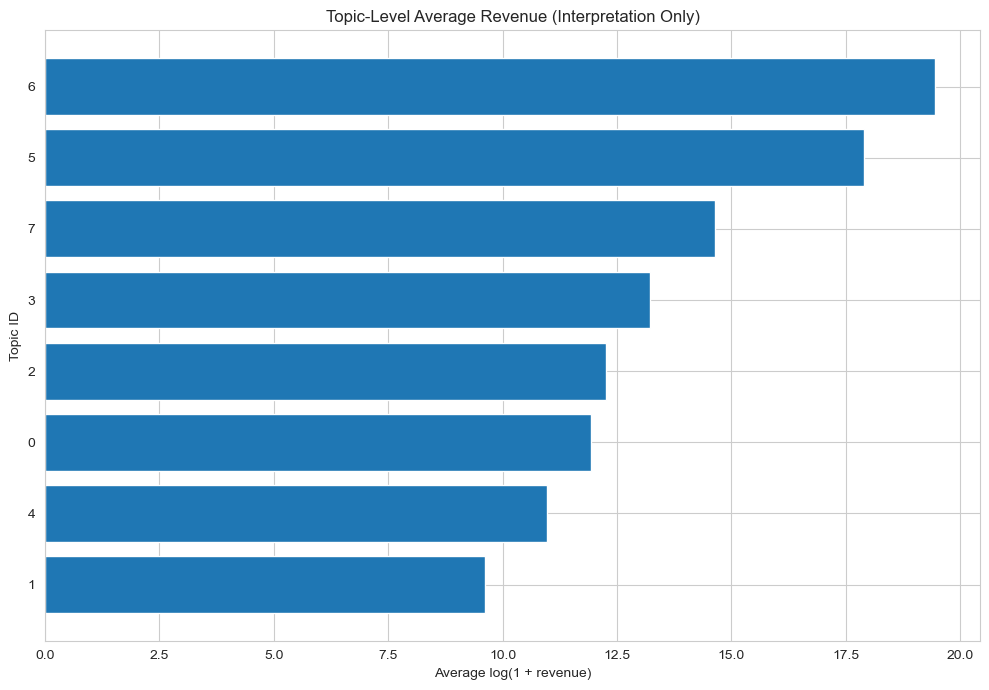

In [26]:
# Virginia Bustos

# Prepare a visualization dataset (avoid outliers)
viz_df = topic_profile_with_words.reset_index().copy()  # reset index for plotting
viz_df = viz_df.sort_values("avg_revenue_log", ascending=True)  # sort by revenue for ordered plot

# Create a horizontal bar chart of average revenue by topic
plt.figure(figsize=(10, 7))  # set figure size
plt.barh(viz_df["topic_id_reduced"].astype(str), viz_df["avg_revenue_log"])  # plot average revenue per topic
plt.xlabel("Average log(1 + revenue)")  # axis label for interpretability
plt.ylabel("Topic ID")                  # topic label
plt.title("Topic-Level Average Revenue (Interpretation Only)")  # chart title
plt.tight_layout()                      # improve spacing
plt.show()                              # render plot


This figure illustrates the **average log-transformed revenue by BERTopic cluster**, highlighting how **semantic themes extracted from expert reviews relate to commercial performance**.

A clear revenue gradient is visible. Topics associated with **high-budget, franchise-oriented content** (such as superhero and animated films) achieve the highest average revenues, reinforcing their strong market scalability. Mid-tier topics, including mainstream drama and action narratives, show moderate revenue outcomes, while **documentary and niche thematic clusters** occupy the lower end of the distribution.

This visualization supports the idea that **early semantic signals in expert discourse can differentiate high- and low-revenue trajectories**, offering value as a complementary tool for strategic forecasting, portfolio diversification, and risk assessment in film production and distribution.


**Linking Thematic Content to Strategic Movie Clusters**

To assess whether early expert review themes align with the strategic movie segments identified through clustering, topic assignments are cross-tabulated with cluster labels. This analysis reveals whether specific narrative themes are disproportionately associated with particular release strategies, budget profiles, or market positions.


In [27]:
# Virginia Bustos

# Select movie-level cluster assignments
# This dataset was created during the clustering section
cluster_assignments = movie_profile[["movie_id", "cluster"]].copy()

# Select movie-level topic assignments from BERTopic
topic_assignments = movie_documents[["movie_id", "topic_id_reduced"]].copy()

# Merge cluster labels and topic labels into a single table
df_topic_cluster = cluster_assignments.merge(
    topic_assignments,     # topic labels per movie
    on="movie_id",         # join key
    how="inner"            # keep only movies present in both analyses
)

# Quick sanity check of merged dataset
print("Topic × Cluster table shape:", df_topic_cluster.shape)
print("Unique clusters:", df_topic_cluster["cluster"].nunique())
print("Unique topics (incl. -1):", df_topic_cluster["topic_id_reduced"].nunique())

df_topic_cluster.head()


Topic × Cluster table shape: (3373, 3)
Unique clusters: 2
Unique topics (incl. -1): 9


,movie_id,cluster,topic_id_reduced
0,33445,1,-1
1,10,1,-1
2,25,1,-1
3,29,1,-1
4,43,1,0


This output summarizes the **integration between movie-level clustering and BERTopic semantic topics**. The resulting table confirms that **3,373 movies** are jointly characterized by **two structural clusters** (from numerical and genre-based clustering) and **nine semantic topics** (including the outlier topic `-1`) derived from expert review text.

The preview indicates that a substantial share of movies (across both clusters) are assigned to the **outlier topic (-1)**, suggesting that many expert reviews contain **generic or cross-cutting language** not distinctive enough to form a coherent semantic topic. This highlights an important distinction: while **structured features can separate films into broad market segments**, textual discourse is more heterogeneous and often less sharply differentiated.

Overall, this combined view reinforces the complementarity of both approaches: **clustering captures market structure**, whereas **topic modeling captures nuanced narrative and critical framing**, together providing a richer foundation for strategic film portfolio analysis.


**Topic Distribution Across Clusters**

This cross-tabulation shows how thematic content extracted from expert reviews is distributed across the identified clusters. Normalized proportions are used to highlight relative differences rather than absolute frequency effects driven by cluster size.


In [28]:
# Virginia Bustos

# Build a raw count table of topics by cluster
topic_cluster_counts = pd.crosstab(
    df_topic_cluster["topic_id_reduced"],  # rows: topics
    df_topic_cluster["cluster"]            # columns: clusters
)

# Normalize counts by cluster to obtain relative proportions
topic_cluster_prop = topic_cluster_counts.div(
    topic_cluster_counts.sum(axis=0),
    axis=1
)

# Display the proportional distribution table
topic_cluster_prop.round(3).head(10)


cluster,0,1
topic_id_reduced,,
-1,0.588,0.620
0,0.048,0.175
1,0.000,0.084
2,0.020,0.047
3,0.020,0.035
4,0.003,0.022
5,0.173,0.006
6,0.139,0.002
7,0.007,0.009


This table shows how **semantic topics are distributed across the two structural clusters**. In both clusters, the outlier topic (−1) dominates, indicating that most expert reviews rely on general evaluative language rather than highly distinctive themes.

Nonetheless, differences remain visible: **Cluster 0** is relatively more associated with **animated and superhero-related topics**, while **Cluster 1** shows higher proportions of **comedy and documentary-oriented discourse**. This suggests that, beyond structural differences, **clusters also differ in the narratives emphasized by critics**, which has implications for positioning and audience targeting.


**Visualization of Topic Concentration by Cluster**

A heatmap is used to visualize the relative concentration of topics within each cluster. Darker cells indicate a stronger association between a topic and a specific strategic cluster, supporting intuitive identification of cluster-specific narratives.


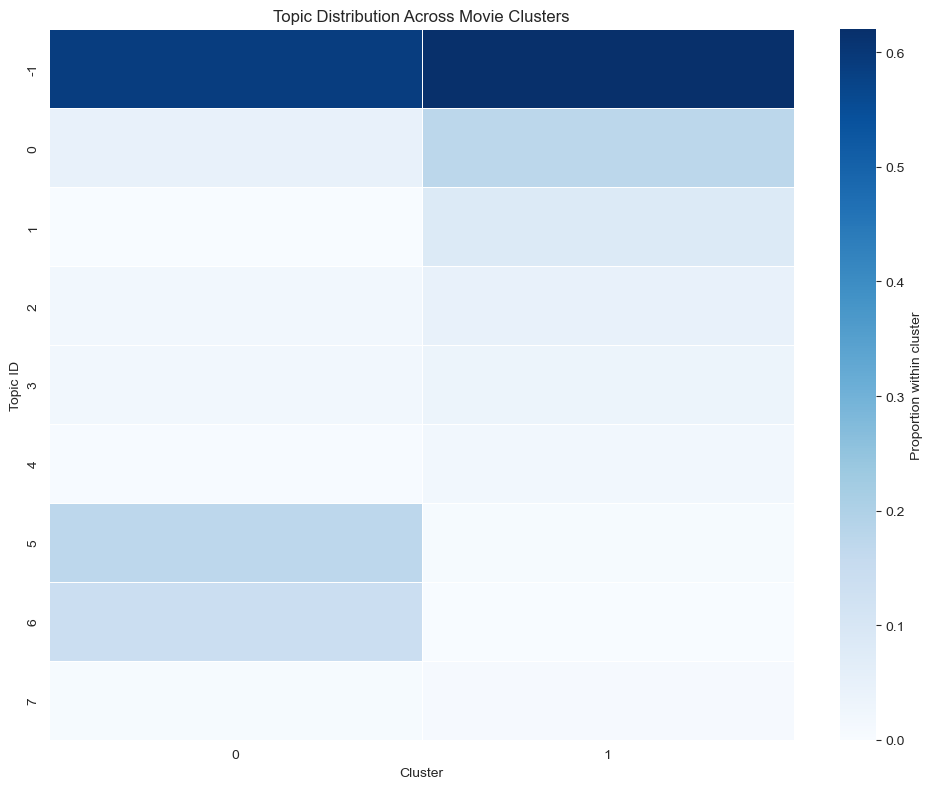

In [29]:
# Virginia Bustos

# Create a heatmap to visualize topic concentration across clusters
plt.figure(figsize=(10, 8))  # set figure size for readability

sns.heatmap(
    topic_cluster_prop,        # normalized topic-cluster proportions
    cmap="Blues",              # color palette emphasizing intensity
    linewidths=0.5,            # grid lines for clarity
    linecolor="white",         # grid line color
    cbar_kws={"label": "Proportion within cluster"}  # legend label
)

# Add descriptive title and axis labels
plt.title("Topic Distribution Across Movie Clusters")
plt.xlabel("Cluster")
plt.ylabel("Topic ID")

# Optimize layout spacing
plt.tight_layout()

# Render the plot
plt.show()


The heatmap visualizes how **semantic topics from expert reviews are distributed across the two movie clusters**. Consistent with earlier results, the **outlier topic (−1)** dominates both clusters, confirming that a large share of reviews use broadly applicable evaluative language rather than highly specialized themes.

Beyond this common baseline, **Cluster 0 shows stronger associations with animation, and franchise-related topics**, while **Cluster 1 concentrates relatively more on comedy and documentary-oriented themes**. From a business perspective, this indicates that **structural movie segments are also differentiated by the narratives emphasized by critics**, offering complementary insights for content positioning, marketing messaging, and portfolio strategy.


## BERTopic - General Analysis & Conclusion

In this section, we applied **BERTopic** to aggregated expert reviews at the movie level to uncover latent thematic structures in critics’ discourse before release. After careful data preparation (exact + fuzzy title matching), we obtained 3,373 rich movie-level documents and generated transformer-based embeddings. BERTopic identified **9 stable topics**, including a large outlier group, reflecting the high linguistic diversity and evaluative nature of professional film criticism. Well-defined topics clearly map to recognizable content categories (e.g., comedy, documentary, horror, animation, superhero, music-related films), confirming that expert reviews encode coherent semantic signals beyond surface genres.

From a business perspective, linking topics to financial variables shows meaningful heterogeneity: **franchise-driven and animated topics exhibit the highest budgets and revenues**, while documentaries and niche themes align with lower commercial outcomes. Although many reviews fall into a generic outlier category, the remaining topics provide valuable **qualitative segmentation** that complements numerical clustering. Overall, BERTopic proves most useful as an **interpretive and strategic tool**, helping explain positioning, narrative framing, and risk–return profiles, rather than as a standalone predictive model for revenue.
